### Capstone Project : Battle of Neighborhood Dublin(week2)

##### Dublin data analytics for business problem 
Idea of this project is If a business person want to open a restaurant in Dublin, help him analyse which area would be better depending on competition and population within Dublin. In recent years Migrations to Ireland are increased and most of the migrant are based at Dublin location. Due to increased housing prices in Dublin city area, people are preferring to locate little away from Dublin, but they find difficult to locate good restaurants. In such scenario, restaurants like Asian, Chinese or Italian cuisine would be blessing for people and they won’t need to visit Dublin city central always.

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
!conda install -c conda-forge folium=0.5.0 --yes

import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



#####  Get Dublin Postsal districts Location data -Major 4 region Data

In [6]:
url = 'https://en.wikipedia.org/wiki/County_Dublin'
response = requests.get(url)
html = response.text
df_gdublin = pd.read_html(html)
df_gdublin= df_gdublin[1]
df_gdublin=df_gdublin.drop(columns=['Name','Area']).reset_index(drop=True)
df_gdublin.rename(columns={'Name.1':'Neighborhood','Population[6]':'Population'}, inplace=True)
df_gdublin.head()

,Neighborhood,Population
0,Dublin City,553165
1,Dún Laoghaire–Rathdown,217274
2,Fingal,296214
3,South Dublin,278749


##### Fetch Dublin location coordinates for dublin postal districts and greater dublin areas. locations of 4 major areas of Dublin

In [44]:
dublin_areas=[]
latitudes=[]
longitudes=[]
geolocator = Nominatim(user_agent="On_explorer")
#extract greater Dublin areas 
for area in df_gdublin['Neighborhood']:
    print(area)
    location = geolocator.geocode(area,timeout=20)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
    
df_gdublin['Latitude'] = latitudes
df_gdublin['Longitude'] = longitudes
df_gdublin

Dublin City
Dún Laoghaire–Rathdown
Fingal
South Dublin


,Neighborhood,Population,Latitude,Longitude,population_per,rest_percent_x,grocery_percent_x,Italianrest_per_x,Asian_per_x,rest_percent_y,grocery_percent_y,Italianrest_per_y,Asian_per_y
0,Dublin City,553165,53.349764,-6.260273,41.115221,18.461538,20.0,18.181818,0.0,18.461538,20.0,18.181818,0.0
1,Dún Laoghaire–Rathdown,217274,53.256721,-6.204865,16.149374,24.615385,40.0,27.272727,0.0,24.615385,40.0,27.272727,0.0
2,Fingal,296214,53.494221,-6.224980,22.016765,29.230769,20.0,45.454545,0.0,29.230769,20.0,45.454545,0.0
3,South Dublin,278749,53.273260,-6.407077,20.718640,27.692308,20.0,9.090909,100.0,27.692308,20.0,9.090909,100.0


##### Postal district locations

In [11]:
latitudes=[]
longitudes=[]
districts=[]
geolocator = Nominatim(user_agent="On_explorer")
#extract greater Dublin areas 
for n in range(1, 25):
    area = 'Dublin {}'.format(n)
    districts.append(area)
    #print(area)
    location = geolocator.geocode(area, timeout=50)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

df_dublin = pd.DataFrame({'Neighborhood':districts, 'Latitude':latitudes, 'Longitude':longitudes})
df_dublin.head(10)

,Neighborhood,Latitude,Longitude
0,Dublin 1,53.352488,-6.256646
1,Dublin 2,53.338940,-6.252713
2,Dublin 3,53.361223,-6.185467
3,Dublin 4,53.327507,-6.227486
4,Dublin 5,53.383454,-6.181923
5,Dublin 6,53.317698,-6.259525
6,Dublin 7,53.360551,-6.284470
7,Dublin 8,53.350263,-6.320213
8,Dublin 9,53.386050,-6.245577
9,Dublin 10,53.343217,-6.360964


##### Dublin location coordinates

In [12]:
address = 'Dublin, Ireland'
geolocator = Nominatim(user_agent="On_explorer")
location = geolocator.geocode(address)
latitude_dublin = location.latitude
longitude_dublin = location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(latitude_dublin, longitude_dublin))

The geograpical coordinate of Dublin are 53.3497645, -6.2602732.


##### Define Foursquare credentials

In [47]:
CLIENT_ID = 'TK02EUO5TJCWNM0OBBLZUNQGF4UAFQSAJCTAW5FEPZCKAVUW' # your Foursquare ID
CLIENT_SECRET = 'XKZAFTTF5V4LH02122JSISTXVUKB32QMNUES4LEEWJYKA5MI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

##### Define Function to get venues in Dublin

In [48]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
       
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Get nearby venues for neighborhood of Dublin postal districts

In [50]:
gdublin_venues= getNearbyVenues(df_gdublin['Neighborhood'],df_gdublin['Latitude'],df_gdublin['Longitude'],radius=8000)
print(gdublin_venues.shape)
gdublin_venues.head(10)

(400, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin City,53.349764,-6.260273,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin City,53.349764,-6.260273,Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop
2,Dublin City,53.349764,-6.260273,Pull&Bear,53.349533,-6.262053,Clothing Store
3,Dublin City,53.349764,-6.260273,Vintage Cocktail Club,53.345127,-6.262851,Cocktail Bar
4,Dublin City,53.349764,-6.260273,The Winding Stair,53.346596,-6.263784,Restaurant
5,Dublin City,53.349764,-6.260273,Brother Hubbard North,53.347137,-6.268377,Café
6,Dublin City,53.349764,-6.260273,Bunsen,53.345547,-6.264331,Burger Joint
7,Dublin City,53.349764,-6.260273,Gate Theatre,53.353113,-6.261997,Theater
8,Dublin City,53.349764,-6.260273,Offbeat Donut Co,53.347435,-6.255535,Donut Shop
9,Dublin City,53.349764,-6.260273,Il Vicoletto,53.344632,-6.263744,Italian Restaurant


In [70]:
#check if duplicate venues are in data , check venue Latitude, Longitude - not same
indextodrop= gdublin_venues[gdublin_venues[['Venue Latitude','Venue Longitude']].duplicated() == True].index
gdublin_venues.drop(index = indextodrop, inplace=True)
dublin_venues= getNearbyVenues(df_dublin['Neighborhood'],df_dublin['Latitude'],df_dublin['Longitude'])
print(dublin_venues.shape)
dublin_venues.head(10)

(1681, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater
2,Dublin 1,53.352488,-6.256646,Holiday Inn Express Dublin City Centre Hotel,53.352306,-6.260955,Hotel
3,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub
4,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant
5,Dublin 1,53.352488,-6.256646,Pull&Bear,53.349533,-6.262053,Clothing Store
6,Dublin 1,53.352488,-6.256646,"Laine, my love",53.351320,-6.251253,Café
7,Dublin 1,53.352488,-6.256646,El Grito Mexican Taqueria,53.357390,-6.256618,Mexican Restaurant
8,Dublin 1,53.352488,-6.256646,Dealz,53.350623,-6.263183,Discount Store
9,Dublin 1,53.352488,-6.256646,Offbeat Donut Co,53.347435,-6.255535,Donut Shop


In [68]:
indextodrop= dublin_venues[dublin_venues[['Venue Latitude','Venue Longitude']].duplicated() == True].index
dublin_venues.drop(index = indextodrop, inplace=True)
dublin_venues.shape
print("Unique category of Dublin districts venues: ", dublin_venues['Venue Category'].nunique())
print("Unique category of Greater Dublin venues: ", len(gdublin_venues['Venue Category'].unique()))

Unique category of Dublin districts venues:  190
Unique category of Greater Dublin venues:  114


##### Prepare data for venues analysis by postal dictricts & Venues Analysis by Major Dublin regions

In [71]:
dublin_venues['Restaurant']=(dublin_venues['Venue Category'].str.contains('Restaurant')).astype(int)
dublin_venues['Italian Restaurant']=(dublin_venues['Venue Category'].str.contains('Italian Restaurant')).astype(int)
dublin_venues['Cafe']=(dublin_venues['Venue Category'].str.contains('Coffee Shop') | dublin_venues['Venue Category'].str.contains('Café')).astype(int)
dublin_venues['Asian']=(dublin_venues['Venue Category'].str.contains('Asian')).astype(int)
dublin_venues['Grocery Store']=(dublin_venues['Venue Category'].str.contains('Grocery Store')).astype(int)
gdublin_venues.head(10)

,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store
0,Dublin City,53.349764,-6.260273,147 Deli,53.353410,-6.259807,Deli / Bodega,0,0,0,0,0
1,Dublin City,53.349764,-6.260273,Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop,0,0,1,0,0
2,Dublin City,53.349764,-6.260273,Pull&Bear,53.349533,-6.262053,Clothing Store,0,0,0,0,0
3,Dublin City,53.349764,-6.260273,Vintage Cocktail Club,53.345127,-6.262851,Cocktail Bar,0,0,0,0,0
4,Dublin City,53.349764,-6.260273,The Winding Stair,53.346596,-6.263784,Restaurant,1,0,0,0,0
5,Dublin City,53.349764,-6.260273,Brother Hubbard North,53.347137,-6.268377,Café,0,0,1,0,0
6,Dublin City,53.349764,-6.260273,Bunsen,53.345547,-6.264331,Burger Joint,0,0,0,0,0
7,Dublin City,53.349764,-6.260273,Gate Theatre,53.353113,-6.261997,Theater,0,0,0,0,0
8,Dublin City,53.349764,-6.260273,Offbeat Donut Co,53.347435,-6.255535,Donut Shop,0,0,0,0,0
9,Dublin City,53.349764,-6.260273,Il Vicoletto,53.344632,-6.263744,Italian Restaurant,1,1,0,0,0


##### Calculate area wise restaurant count

In [72]:
dublin_rest = dublin_venues.groupby('Neighborhood').sum().reset_index()
dublin_rest = dublin_rest.drop(columns=['Venue Latitude','Venue Longitude'])
dublin_rest.head(10)

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store
0,Dublin 1,5335.248810,-625.664569,16,3,18,0,1
1,Dublin 10,4747.546273,-566.125760,9,1,5,1,2
2,Dublin 11,4591.248770,-541.165916,11,0,7,2,3
3,Dublin 12,3785.757563,-449.346514,6,1,5,1,5
4,Dublin 13,3042.982124,-346.296849,12,1,11,0,0
5,Dublin 14,5329.864730,-625.820118,24,2,15,1,1
6,Dublin 15,5125.913717,-613.364020,15,3,8,2,2
7,Dublin 16,852.091549,-100.741519,0,0,1,0,0
8,Dublin 17,4005.027056,-465.711838,14,1,7,2,2
9,Dublin 18,3034.733309,-352.450684,4,0,11,0,0


##### Visualize data retrieved and derived

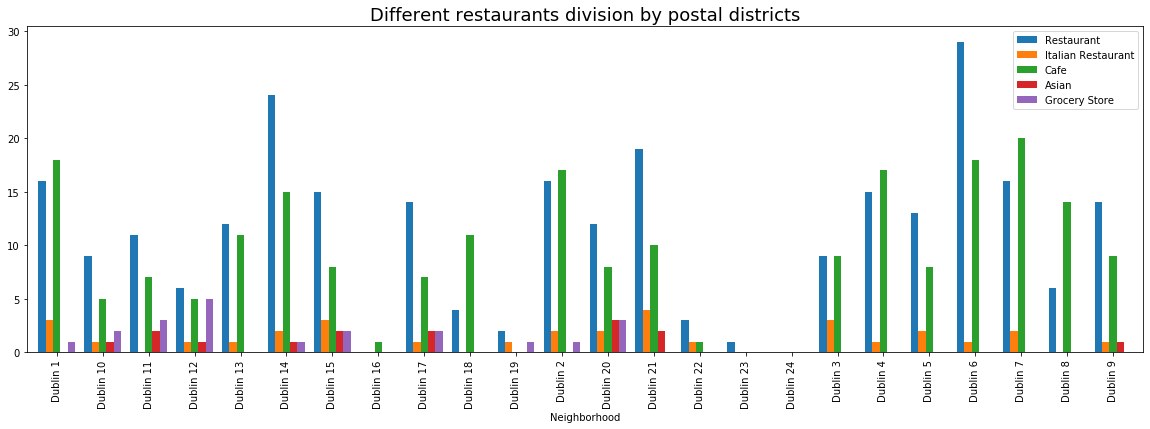

In [77]:
ax1=dublin_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Asian','Grocery Store'], kind='bar',figsize = (20,6), width = 0.8)
ax1.set_title("Different restaurants division by postal districts", fontsize = 18)
plt.show()

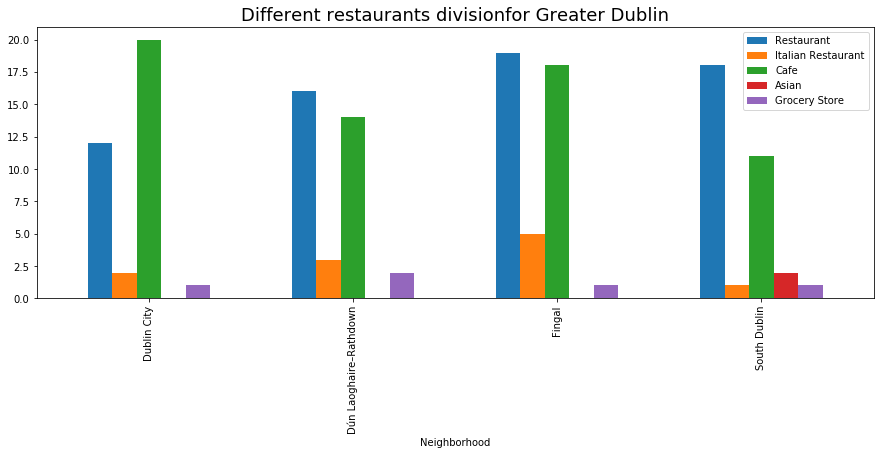

In [78]:
ax1=gdublin_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Asian','Grocery Store'], kind='bar',figsize = (15,5), width = 0.6)
ax1.set_title("Different restaurants divisionfor Greater Dublin",fontsize = 18)
plt.show()

##### Calculate % of restaurants areawise

In [82]:
totalrest =dublin_rest['Restaurant'].sum()
dublin_rest['rest_percent']=(dublin_rest['Restaurant']/totalrest)*100
totalgrocery = dublin_rest['Grocery Store'].sum()
dublin_rest['grocery_percent']=(dublin_rest['Grocery Store']/totalgrocery)*100
totalrest=dublin_rest['Italian Restaurant'].sum()
dublin_rest['Italianrest_per']=(dublin_rest['Italian Restaurant']/totalrest)*100
totalrest=dublin_rest['Asian'].sum()
dublin_rest['Asian_per']=(dublin_rest['Asian']/totalrest)*100
dublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store,rest_percent,grocery_percent,Italianrest_per,Asian_per
0,Dublin 1,5335.248810,-625.664569,16,3,18,0,1,6.015038,4.761905,9.375,0.000000
1,Dublin 10,4747.546273,-566.125760,9,1,5,1,2,3.383459,9.523810,3.125,6.666667
2,Dublin 11,4591.248770,-541.165916,11,0,7,2,3,4.135338,14.285714,0.000,13.333333
3,Dublin 12,3785.757563,-449.346514,6,1,5,1,5,2.255639,23.809524,3.125,6.666667
4,Dublin 13,3042.982124,-346.296849,12,1,11,0,0,4.511278,0.000000,3.125,0.000000


#### calculate % for greater dublin

In [83]:
totalrest_gd=gdublin_rest['Restaurant'].sum()
gdublin_rest['rest_percent']=(gdublin_rest['Restaurant']/totalrest_gd)*100
totalgrocery = gdublin_rest['Grocery Store'].sum()
gdublin_rest['grocery_percent']=(gdublin_rest['Grocery Store']/totalgrocery)*100
totalrest_gd=gdublin_rest['Italian Restaurant'].sum()
gdublin_rest['Italianrest_per']=(gdublin_rest['Italian Restaurant']/totalrest_gd)*100
totalrest_gd=gdublin_rest['Asian'].sum()
gdublin_rest['Asian_per']=(gdublin_rest['Asian']/totalrest_gd)*100
gdublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store,rest_percent,grocery_percent,Italianrest_per,Asian_per
0,Dublin City,5334.976450,-626.027320,12,2,20,0,1,18.461538,20.0,18.181818,0.0
1,Dún Laoghaire–Rathdown,5325.672110,-620.486547,16,3,14,0,2,24.615385,40.0,27.272727,0.0
2,Fingal,5295.927904,-616.273041,19,5,18,0,1,29.230769,20.0,45.454545,0.0
3,South Dublin,5220.779514,-627.893517,18,1,11,2,1,27.692308,20.0,9.090909,100.0


##### plot for population % and restauranet % for greater Dublin

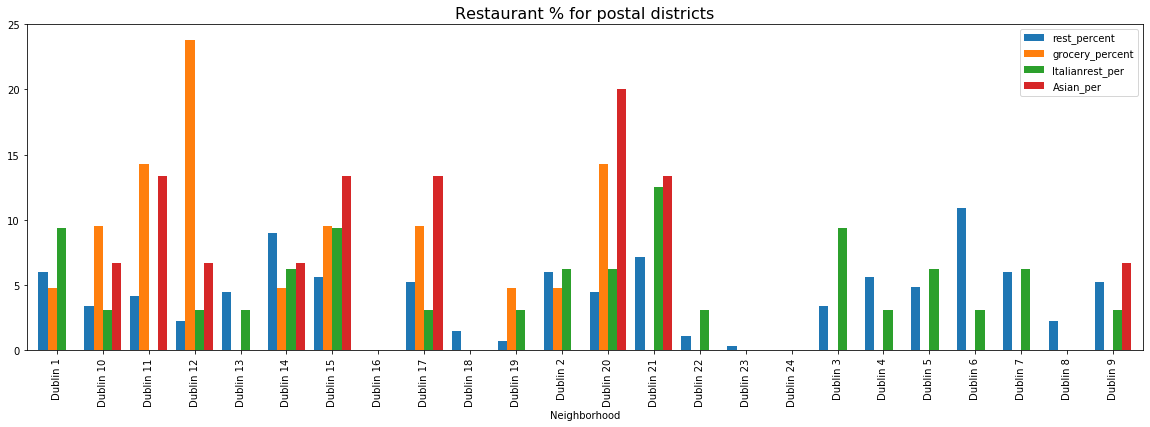

In [84]:
totalpopulation= df_gdublin['Population'].sum()
df_gdublin['population_per']=(df_gdublin['Population']/totalpopulation)*100
df_gdublin=df_gdublin.merge(gdublin_rest[['Neighborhood','rest_percent','grocery_percent','Italianrest_per','Asian_per']], on='Neighborhood')
ax1=dublin_rest.plot(x='Neighborhood',y=['rest_percent','grocery_percent','Italianrest_per','Asian_per'], kind='bar',figsize = (20,6), width = 0.8)
ax1.set_title("Restaurant % for postal districts", fontsize = 16)
plt.show()

In [85]:
def get_color(category):
    if 'Asian' in category:
        col = 'red'
    if 'Grocery' in category:
        col = 'orange'
    if 'Italian' in category:
        col = 'green'
    return col

map_dublin = folium.Map(location=[latitude_dublin,longitude_dublin], zoom_start=10)
dublin_plot = dublin_venues[dublin_venues['Venue Category'].str.contains('Asian') | dublin_venues['Venue Category'].str.contains('Grocery') | dublin_venues['Venue Category'].str.contains('Italian')] 
for lat, lon,area, cat in zip(dublin_plot['Venue Latitude'], dublin_plot['Venue Longitude'],dublin_plot['Neighborhood'],dublin_plot['Venue Category']):
    folium.CircleMarker([lat, lon], radius=5, 
                        popup=area,
                        color=get_color(cat), 
                        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)
    
map_dublin

In [86]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head(10)

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Outdoor Sculpture,Outlet Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [40]:
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head(10)

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Outdoor Sculpture,Outlet Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [87]:
dublin_grouped = dublin_onehot.groupby('Neighborhood').mean().reset_index()
dublin_grouped

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Outdoor Sculpture,Outlet Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0.000000,0.00,0.00,0.00,0.0100,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.000000,0.02,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.020000,0.010000,0.000000,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.090000,0.01,0.010000,0.00,0.000000,0.01,0.000000,0.010000,0.000000,0.01,0.000000,0.010000,0.010000,0.000000,0.000000,0.0,0.01,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.01,0.000000,0.000000,0.000000,0.00,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.030000,0.010000,0.000000,0.030000,0.000000,0.01,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.01,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.01,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.140000,0.000000,0.01,0.01,0.000000,0.000000,0.050000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.01,0.020000,0.000000,0.000000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000

In [88]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [89]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dublin_grouped['Neighborhood']

for ind in np.arange(dublin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Pub,Coffee Shop,Café,Restaurant,Theater,Ice Cream Shop,Italian Restaurant,Hotel,Cocktail Bar,Plaza
1,Dublin 10,Supermarket,Park,Fast Food Restaurant,Convenience Store,Tram Station,Bar,Coffee Shop,Hotel,Diner,Farm
2,Dublin 11,Supermarket,Coffee Shop,Hotel,Pub,Fast Food Restaurant,Restaurant,Grocery Store,Park,Diner,Gym Pool
3,Dublin 12,Supermarket,Park,Grocery Store,Pub,Bar,Hotel,Coffee Shop,Tram Station,Shopping Mall,Fast Food Restaurant
4,Dublin 13,Seafood Restaurant,Café,Pub,Coffee Shop,Deli / Bodega,Golf Course,Beach,Trail,Train Station,Lighthouse


##### Analysis
Overall Asian Restaurants have less existence in Dublin City (Dublin 1, Dublin 2).
Fingal and Dun-Laghorie areas, region which has plenty of restaurants and cafe otherwise.
Assuming Asian migrated peoples are settling in Dublin 15, Dublin 2, Dublin 4 postal districts majorly, hence Dubin2 and Dublin4 can be a good potential area for Asian restaurant

##### Conclusion
Dublin City, Fingal and Dun-Laghorie would be potential regions to open a Asian Restaurant.

Assuming increasing population in Dublin 4, Dublin 8 and Fingal region, Asian restaurants would have good potential in these areas of Dublin